# Reactive Greedy Randomized Adaptive Search Procedure for semantic Semi-supervised Trajectory Segmentation (RGRASP-SemTS)  

This is an example of how to use the RGRASP-SemTS algorithm using the fishing vessels dataset. 
Please make sure you have all the libraries installed in your python environment.

   tid  sid  latitude  longitude                time  direction_inference  \
0    1    1    -5.778    -35.206 2004-04-14 01:31:00                  0.0   
1    1    1    -5.778    -35.206 2004-04-14 01:44:00                  0.0   

   speed_inference_m_s        label  
0                  0.0  NOT_FISHING  
1                  0.0  NOT_FISHING  
               tid          sid     latitude    longitude  \
count  5190.000000  5190.000000  5190.000000  5190.000000   
mean     19.670135    16.013102     0.391509   -36.581944   
std      11.886607    11.237662     2.961786     3.757922   
min       1.000000     1.000000    -8.058000   -47.290000   
25%      10.000000     7.000000    -1.272250   -38.033750   
50%      19.000000    14.000000     0.463000   -36.191500   
75%      31.000000    24.000000     3.108750   -34.586250   
max      40.000000    47.000000     5.918000   -28.791000   

       direction_inference  speed_inference_m_s  
count          5190.000000          5190.000000  
mean

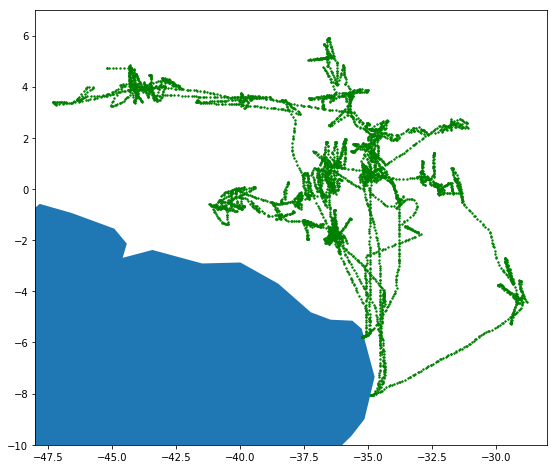

In [4]:
import pandas
import random
import numpy as np
import algorithm.RGRASPSemTS as rgrasp
import algorithm.Evaluate as eval_rg
import math
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib


## read files as a dataframes
dframe = pandas.read_csv('./datasets/fishingvessels/fishingvessels.csv', header=0, delimiter=',', parse_dates=['time'])
print(dframe.head(2))
print(dframe.describe())

# convert time column to string in format YYYY-MM-DD hh:mm:ss
dframe['time'] = dframe['time'].astype(str)

# check the number of trajectories
print('Unique trajectory ids', dframe["tid"].unique())

# visualizing the dataset on a map
geometry = [Point(xy) for xy in zip(dframe['longitude'], dframe['latitude'])]
gdf = GeoDataFrame(dframe, geometry=geometry)   

#A simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(12, 8)), marker='o', markersize=2, color='green')
ax.set_xlim([-48.,-28.])
ax.set_ylim([-10.,7.])

plt.show()

# Scaling the data for RGRASP-SemTS works with distance similarity functions. 
To avoid that a trajectory feature has a higher importance than others, it is important to scale your data. 
In this example, the MinMaxScaler from the sklearn package is used.

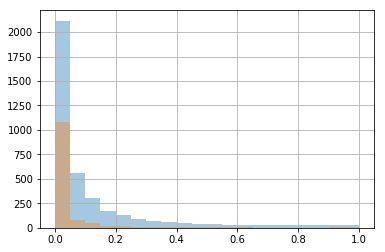

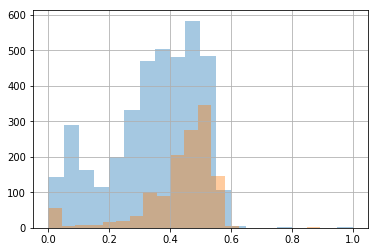

In [5]:
# scaling the trajectory point features data from 0. to 1 with MinMaxScaler
scaler = MinMaxScaler()
# dframe[['direction_inference','speed_inference_m_s','distance_inference_m']] = scaler.fit_transform(dframe[['direction_inference','speed_inference_m_s','distance_inference_m']].to_numpy())
dframe[['direction_inference','speed_inference_m_s']] = scaler.fit_transform(dframe[['direction_inference','speed_inference_m_s']].to_numpy())

# checking the distribution of the point features by class
# dframe_to_plot = dframe[['direction_inference','speed_inference_m_s', 'distance_inference_m','label']].groupby('label')
dframe_to_plot = dframe[['direction_inference','speed_inference_m_s','label']].groupby('label')

dframe_to_plot.direction_inference.hist(bins=20, alpha=0.4)
plt.show()

dframe_to_plot.speed_inference_m_s.hist(bins=20, alpha=0.4)
plt.show()

# RGRASP-SemTS input data and parameters setup
## Input data
Please make sure that your data is the proper format: 
1. The unlabeled dataset: (tid, latitude, longitude, time, traj_feat1,..., traj_feat_N)
2. The labeled dataset: (tid, latitude, longitude, time, traj_feat1,..., traj_feat_N, class_label)

In [6]:
print(dframe.head(2))
# store geometry for future plot
geom = dframe['geometry']
dframe = dframe.drop(['geometry'], axis=1)
# splitting the data 
# Let's select some examples to be used as a trajectory dataset to be segmented
list_of_tids_to_segment = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
list_of_tids_for_labels = [28,31,32,33,34,35,38,39,40]
# Select the trajectory data as a numpy array, and remove the labeled column
# This column will be forecasted by the RGRASP-SemTS algorithm
y_truth_sid = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)]['sid'].to_numpy()
dframe = dframe.drop(["sid"], axis=1)
trajectory_data = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)].to_numpy()[:,0:-1]
# store the true values of y for evaluating the algorithm further
y_truth_cls = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)].to_numpy()[:,-1]


# Select the labeled dataset as a numpy array
labeled_dataset = dframe.loc[dframe['tid'].isin(list_of_tids_for_labels)].to_numpy()

# print some lines of the selected data
print(trajectory_data[:2])
print(labeled_dataset[:2])


   tid  sid  latitude  longitude                 time  direction_inference  \
0    1    1    -5.778    -35.206  2004-04-14 01:31:00                  0.0   
1    1    1    -5.778    -35.206  2004-04-14 01:44:00                  0.0   

   speed_inference_m_s        label                    geometry  
0                  0.0  NOT_FISHING  POINT (-35.20600 -5.77800)  
1                  0.0  NOT_FISHING  POINT (-35.20600 -5.77800)  
[[1 -5.778 -35.205999999999996 '2004-04-14 01:31:00' 0.0 0.0]
 [1 -5.778 -35.205999999999996 '2004-04-14 01:44:00' 0.0 0.0]]
[[28 4.06 -44.626999999999995 '2004-06-19 01:00:00' 0.0633888888888889
  0.22584400465657742 'FISHING']
 [28 4.048 -44.55 '2004-06-19 01:33:00' 0.0020555555555555557
  0.5087310826542492 'FISHING']]


# Running RGRASP-SemTS 
## Parameters setup
1. max_value: is a the maximal distance between two trajectory points. If not available, you may want to use the square root of the number of trajectory features.
2. seed: An integer seed for reproducing the results of your experiments.
3. reactive_proportion: a value between 0-1 to update the alpha and min_time lists prob. of selection
4. max_iterations: The maximal number of iterations to run the GRASP strategy.
5. lists_size: The number of elements for the alpha and min_time lists.
6. min_time_bounds: The boundaries of the minimal mintime value and maximal mintime value for creating a segment.

## The output of the method
The outcome of RGRASP-SemTS is the total cost of the solutions given to each segmented trajectory (cost), y_pred_sid as an array with all the segment ids of each trajectory point following the same order of the trajectory_data multidimensional array, and y_pred_cls as an array with the class for each trajectory point following the same order of the trajectory_data multidimensional array. 

In [7]:
# RGRASPSem-TS input parameters
max_value = math.sqrt(2.)
seed = 1415
reactive_proportion = .1
max_iterations = 50
lists_size = 10
# min time min and max bounds in seconds (10 minutes, 4 hours)
min_time_bounds=[10*60,4*60*60]

cost, y_pred_sid, y_pred_cls = rgrasp.execute(seed, trajectory_data, labeled_dataset, reactive_proportion, lists_size, max_iterations, max_value, min_time_bounds)

print(cost, y_pred_sid, y_pred_cls)

68.87289378155793 [ 1  1  1 ... 40 40 40] ['FISHING', 'FISHING', 'FISHING', 'FISHING', 'FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'NOT_FISHING', 'N

## Evaluating the results
You may want to evaluate the RGRASP-SemTS results using supervised measures such as accuracy, or unsupervised such as segment purity and coverage. For full reference of segment purity and coverage, please check the GRASP-UTS paper in the following link https://www.tandfonline.com/doi/abs/10.1080/13658816.2014.938078 , or the author's version available at https://www.researchgate.net/publication/268217728_GRASP-UTS_an_algorithm_for_unsupervised_trajectory_segmentation

In [8]:
# A point by point accuracy
matches = np.sum(y_truth_cls == y_pred_cls)
print('The number of points that the classes matched is '+str(matches)+' from a total of '+str(len(y_truth_cls)))
print('Percentage is '+str(matches/float(len(y_truth_cls))))
purity = eval_rg.segment_purity(y_truth_cls, y_pred_sid)
coverage = eval_rg.segment_coverage(y_truth_sid, y_pred_sid)
print('The average purity is '+str(purity[1]))
print('The average coverage is '+str(coverage[1]))

The number of points that the classes matched is 2864 from a total of 3695
Percentage is 0.7751014884979702
The average purity is 0.880066970350132
The average coverage is 0.6983266724310861


# Visualizing the final results

You may want to plot side by side the results for each class. Here's an example of how to do it with geopandas.

/Users/asj/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/asj/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


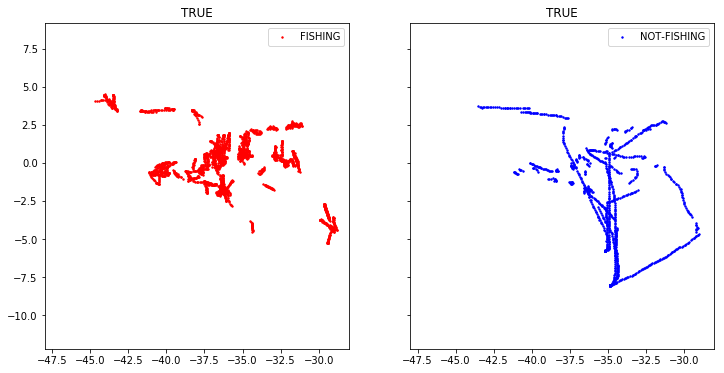

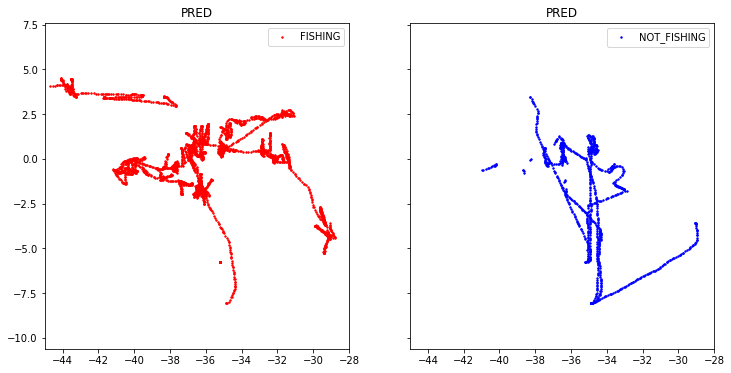

In [9]:
# Plot true values
true_fishing_df = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)][dframe['label'] == 'FISHING']
# print(true_fishing_df.head(3))
true_not_fishing_df = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)][dframe['label'] == 'NOT_FISHING']
# print(true_not_fishing_df.head(3))

fig, axes = plt.subplots(1, 2,figsize=(12,6), sharex=True, sharey=True)

# creating geometry columns
geometry = [Point(xy) for xy in zip(true_fishing_df['longitude'], true_fishing_df['latitude'])]
gdf_fishing = GeoDataFrame(true_fishing_df, geometry=geometry)
geometry = [Point(xy) for xy in zip(true_not_fishing_df['longitude'], true_not_fishing_df['latitude'])]
gdf_not_fishing = GeoDataFrame(true_not_fishing_df, geometry=geometry)
ax = gdf_fishing.plot(ax=axes[0], marker='o', markersize=2, color='red', label='FISHING')
ax.legend(loc="upper right")
ax.set_xlim([-48.,-28.])
ax.set_ylim([-10.,7.])
ax.set_title('TRUE')
ax = gdf_not_fishing.plot(ax=axes[1], marker='o', markersize=2, color='blue', label='NOT-FISHING')
ax.set_title('TRUE')
ax.legend(loc="upper right")
ax.set_xlim([-48.,-28.])
ax.set_ylim([-10.,7.])
plt.show()

# Plot the forecasted values
pred_df = dframe.loc[dframe['tid'].isin(list_of_tids_to_segment)]
pred_df = pandas.concat([pred_df, pandas.DataFrame({'p_label': y_pred_cls})], axis=1)
# print(pred_df.head(3))

pred_fishing_df = pred_df[pred_df['p_label'] == 'FISHING']
# print(pred_fishing_df.head(3))
pred_not_fishing_df = pred_df[pred_df['p_label'] == 'NOT_FISHING']
# print(pred_not_fishing_df.head(3))

fig, axes = plt.subplots(1, 2, figsize=(12,6),sharex=True, sharey=True)

# creating geometry columns
geometry = [Point(xy) for xy in zip(pred_fishing_df['longitude'], pred_fishing_df['latitude'])]
gdf_fishing = GeoDataFrame(pred_fishing_df, geometry=geometry)
geometry = [Point(xy) for xy in zip(pred_not_fishing_df['longitude'], pred_not_fishing_df['latitude'])]
gdf_not_fishing = GeoDataFrame(pred_not_fishing_df, geometry=geometry)
ax = gdf_fishing.plot(ax=axes[0], marker='o', markersize=2, color='red', label='FISHING')
ax.set_title('PRED')
ax.legend(loc="upper right")
ax.set_xlim([-45.,-28.])
ax.set_ylim([-10.,7.])
ax = gdf_not_fishing.plot(ax=axes[1], marker='o', markersize=2, color='blue', label='NOT_FISHING')
ax.set_title('PRED')
ax.legend(loc="upper right")
ax.set_xlim([-45.,-28.])
ax.set_ylim([-10.,7.])
plt.show()